# Linear Regression


# Introduction

<h6> Objective </h6>

> The objective of this assignment is to implement LS and LMS models using basic and self sought data. In essence, finding a way to classify regressional data with these models. 

# Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
df = pd.read_excel("Concrete_Data.xls")
df.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


<h6> About the data </h6>

> This data is a regression based dataset from UCI Machine Learning Repository$^{1}$ that uses the attributes of component mixtures, age, and overall makeup to determine the compressive strength in megapascals of the cement mixture. Therefore, certain amounts of water, cement, superplasticizer, coarse aggregate and aging could result in a different concrete compressive strength and that is the target attribute we are trying to predict. The `df.describe()` method shows us some insight on the data. We can see that there are 1030 entries for each element and that there are no null values. Furthermore, diving deeper we see that the average age for all of the entries is about 45 days. Meaning that majority of the concrete on average has been out for 45 days. The quartile for it is very vast though as the minimum age is 1 day and the maximum is 365 days. The rest of the means are significant but they aren't very informative since we aren't sure yet how much each component actually effects the data. We will see the effect of each component in the graphs below.

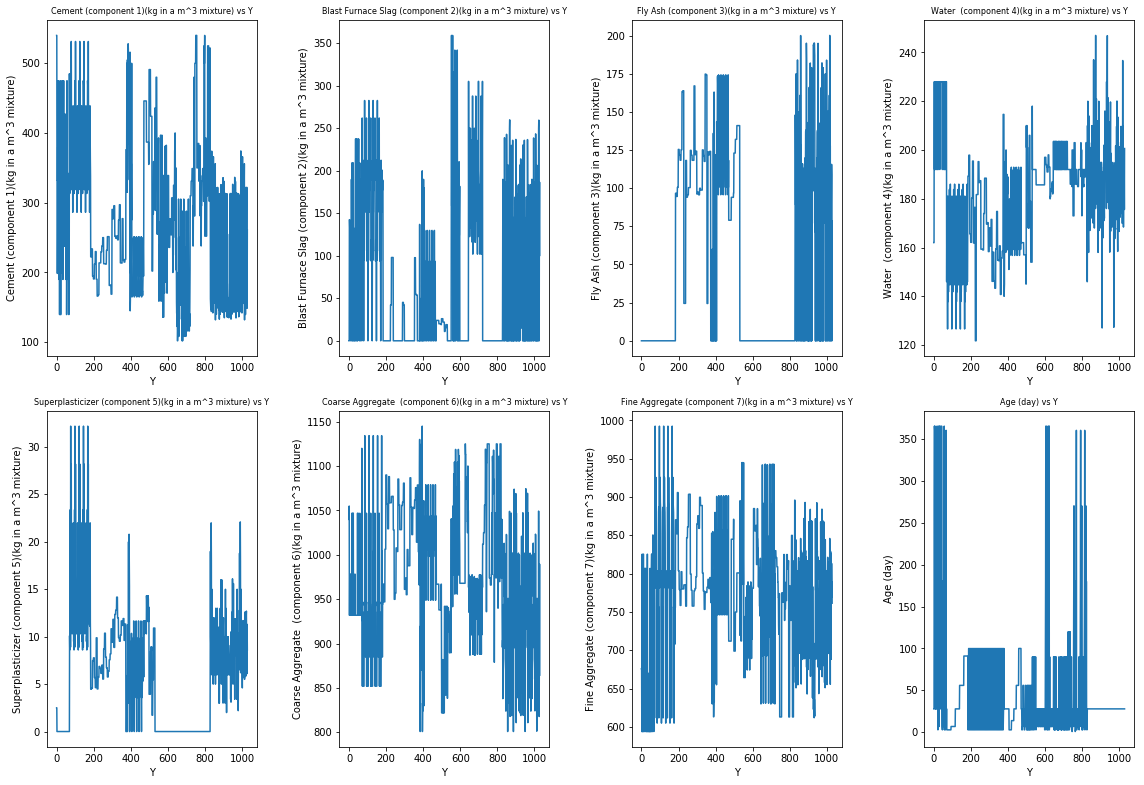

In [3]:
fig = plt.figure(figsize=(16,16))
plt.clf() 
for i in range(8):
    plt.subplot(3, 4, i+1) 
    plt.title(df.columns.values[i] + " vs Y" , fontdict={'fontsize': 8, 'fontweight': 'medium'})
    plt.plot(df.iloc[:,i]) 
    plt.ylabel(df.columns.values[i])
    plt.xlabel("Y")
fig.tight_layout()

<h6> Understanding the graphs </h6>

> This plot shows us the (X,Y) graphing of points as the column number increased. The actual plot between the X and Y is not useful, however, this plot gives us an understanding of the general distribution of the data. For instance, we see that some components, such as the fly ash (component 3) is highly sporadic. There are some that are very high containing about 200 kgs in a $m^3$ mixture, whereas some had a low of 0 kgs in a $m^3$ mixture. This is very similar to the Superplasticizers (component 5) and Age. The other attributes seemed to be distributed evenly across the data points.


# Method

### Super Class Definition

In [4]:
from abc import ABC, abstractmethod

# Super class for machine learning models 

class BaseModel(ABC):
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    
class LinearModel(BaseModel):
    """
        Abstract class for a linear model 
        
        Attributes
        ==========
        w       ndarray
                weight vector/matrix
    """

    def __init__(self):
        """
            weight vector w is initialized as None
        """
        self.w = None

    # check if the matrix is 2-dimensional. if not, raise an exception    
    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    def train(self, X, T):
        """
            train linear model
            
            parameters
            -----------
            X     2d array
                  input data
            T     2d array
                  target labels
        """        
        pass
    
    @abstractmethod
    def use(self, X):
        """
            apply the learned model to input X
            
            parameters
            ----------
            X     2d array
                  input data
            
        """        
        pass 

### Least Squares

<h6> Explanation </h6>

> Least Squares (LS) is an algorithm that generates weightings with the predictors and the target that it has currently. This means that for every column of predictors (X), there is a weighting associated with it. Additionally, there is a bias weighting that is used for the movement of the line across the y axis at the origin. This helps so that the LS predictor does not go through the origin and has some leniency for where it can move. This is shown in the code when I do `self.add_ones(X)` which uses the `super class - LinearModel` method to append a series of 1's to the 2d matrix of predictors (X). This allows for each set of targets to have a $W_{0}$ that allows the prediction to slide up or down the y axis. The rest of the `train(.) function ` after adding the bias, makes the prediction for the weightings itself. This weighting vector is produced by taking the biased X (X's with 1 column appended in front) and finds the weightings with the corresponding targets. We do a dot product of the predictiors with the transpose of the predictors and we find the inverse of that. This is done so that we can find the necessary values and then scale the value via the determinant inverse. This produces a 2d matrix that is then dotted with the transpose of the predictors. This produces a 2d matrix of n samples but 1 column. This can be dotted with the transpose to find a vector of dotted products. Ultimately, this gives us the closest predictions from the predictors to the target. Lastly, the `use(.)` function uses the predictor variables (X) with the weightings to produce the predicted target values. These are the predictions that we use.

In [5]:
# Linear Regression Class for least squares
class LinearRegress(LinearModel): 
    """ 
        LinearRegress class 
        
        attributes
        ===========
        w    nd.array  (column vector/matrix)
             weights
    """
    
    def __init__(self):
        LinearModel.__init__(self)
        
    # train lease-squares model
    def train(self, X, T):
        biasX = self.add_ones(X)
        self.wei = np.linalg.pinv(biasX.T @ biasX) @ biasX.T @ T
    
    # apply the learned model to data X
    def use(self, X):
        vals = self.add_ones(X) @ self.wei
        return vals

### Least Mean Squares

<h6> Explanation </h6>

> Least Mean Squares (LS) is an stochastic gradient descent algorithm which slowly seeks to prediction one data sample at a time. This in return allows for the algorithm to move by one X value (aka , d predictor values) and one Y value (one target value). This in turn allows us to work one sample at a time and see the difference that that individual sample makes on the new updated weightings. Essentially allowing the line to move up and down. `train_step(.)` method, updates the weightings for that object of the LMS class. For instance, if you make a new instance of the LMS class i.e `randomVariable = LMS(0.2)` it creates a new set of weightings (inherited by the superclass) and then sets the alpha value to 0.2. Then when you use the train step, the field variable `self.w` for that specific instance created will update. We take in the predictor variables (X) and we add a bias term so that it can slide across the y axis. Then we come up with a prediction for all the weights, stored in `val`. This is then subtracted from the total weights (updating the weights) and can use the `use(.)` method to try the new updated weighting on the target set. This is the plot that we end up seeing. The `train(.)` method does the same exact thing however, it does it in batch training. It uses `train_step(.)` multiple times until it comes up with one single weighting after updated multiple times that can then be used on the predictor variables.

In [6]:
import collections 
from IPython.core.debugger import set_trace

# LMS class 
class LMS(LinearModel):
    """
        Lease Mean Squares. online learning algorithm
    
        attributes
        ==========
        w        nd.array
                 weight matrix
        alpha    float
                 learning rate
    """

    
    def __init__(self, alpha):
        LinearModel.__init__(self)
        self.alpha = alpha
        
    
    # batch training by using train_step function
    def train(self, X, T):
        for x, t in zip(X, T):
            self.train_step(x, t)
            
    # train LMS model one step
    def train_step(self, x, t):
        biasX = np.insert(x, 0, 1)
        
        biasX = biasX.reshape((biasX.shape[0], 1))
        
        if self.w is None: 
            self.w = np.zeros(biasX.shape[0])
            self.w = self.w.reshape((biasX.shape[0],1))
                
        val = (self.alpha * ((self.w.T @ biasX)- t) * biasX)
        
        self.w -= val
        
    # apply the current model to data X
    def use(self, X):
        biasX = self.add_ones(X)
        return biasX @ self.w

### Preliminary Test

In this following tests, we examine if the implementation is correct with a simple test data, $f(x) = -2 x + 3.2$ where $x \in \{0, 1, 2, \dots, 9, 10 \}$. 

In [7]:
X = np.linspace(0,10, 11).reshape((-1, 1))
T = -2 * X + 3.2

In [8]:
# least square model
ls = LinearRegress()

ls.train(X, T)
t = ls.use(X)
t

array([[  3.2],
       [  1.2],
       [ -0.8],
       [ -2.8],
       [ -4.8],
       [ -6.8],
       [ -8.8],
       [-10.8],
       [-12.8],
       [-14.8],
       [-16.8]])

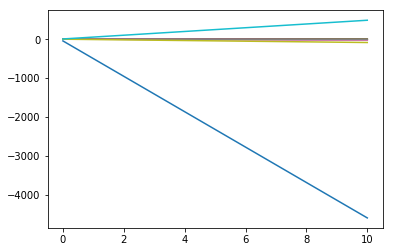

In [9]:
# least mean square model
lms = LMS(0.1)

for x, t in zip(X, T):
    lms.train_step(x, t)
    plt.plot(lms.use(X))

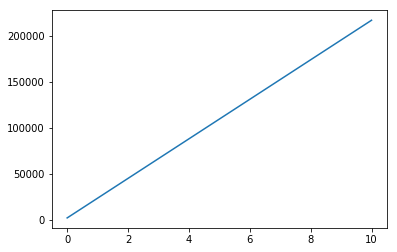

In [10]:
lms.train(X, T)
plt.plot(lms.use(X))

# Experiments

In [11]:
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


In [12]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y = y.reshape((y.shape[0], 1))
# y = np.log(y+1)

</h6> Normalization </h6>

> Without the normalization, the data may be spread out too much, as looking at the data above we see much different scales for all of the values. For example, Age is on a scale between 28 - 300 (days) whereas Fine Aggregate is on a scale between 600 - 800 (mixtures). This may change the data, although I believe it won't change it that significantly. As we can see that it normalized the data around 0 mean for all of the predictor variables but it still is widely different.

In [13]:
mu = np.mean(X, axis = 0, dtype=np.float)
std = np.std(X, axis = 0, dtype=np.float)
mu, std
normX = (X - mu) / std
pd.DataFrame(normX).describe()

,0,1,2,3,4,5,6,7
count,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03
mean,4.335798e-17,-1.117607e-15,1.267056e-15,5.503688e-16,3.987102e-16,-9.011131e-17,-4.575358e-16,1.534910e-16
std,1.000486e+00,1.000486e+00,1.000486e+00,1.000486e+00,1.000486e+00,1.000486e+00,1.000486e+00,1.000486e+00
min,-1.715219e+00,-8.568863e-01,-8.471320e-01,-2.802333e+00,-1.038944e+00,-2.212137e+00,-2.240913e+00,-7.073594e-01
25%,-8.500258e-01,-8.568863e-01,-8.471320e-01,-7.808013e-01,-1.038944e+00,-5.265140e-01,-5.319534e-01,-6.123314e-01
50%,-7.912996e-02,-6.017760e-01,-8.471320e-01,1.608624e-01,2.460198e-02,-6.328926e-02,7.401267e-02,-2.797331e-01
75%,6.589771e-01,8.007508e-01,1.001836e+00,4.888051e-01,6.627297e-01,7.267662e-01,6.291904e-01,1.637312e-01
max,2.477918e+00,3.310688e+00,2.281122e+00,3.065497e+00,4.354156e+00,2.214232e+00,2.733101e+00,5.057677e+00


Text(0,0.5,'Prediction')

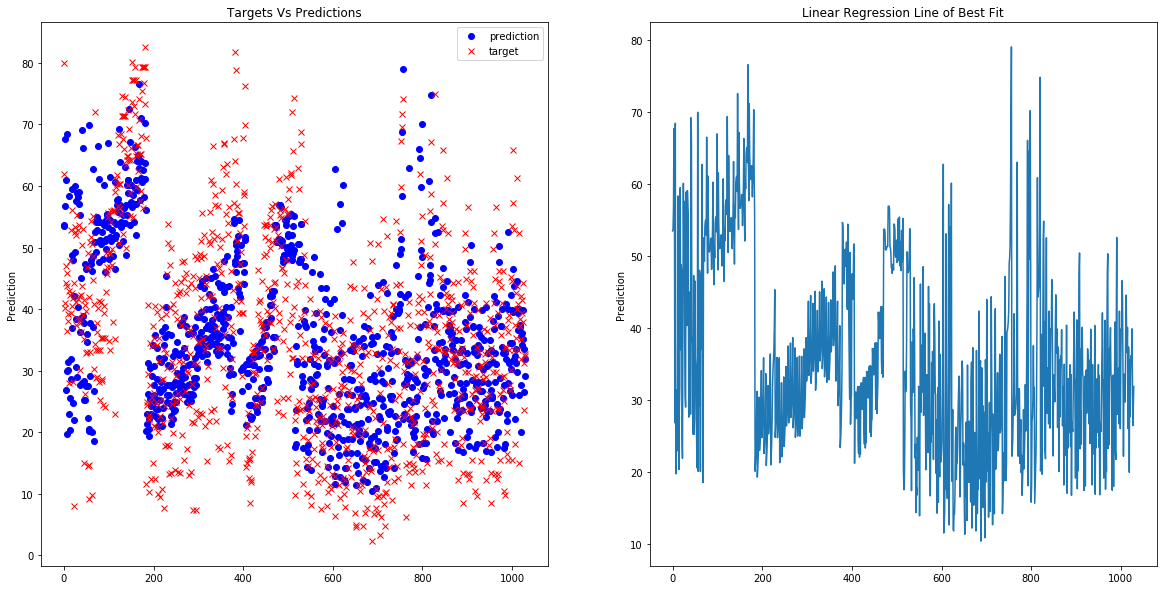

In [14]:
data_ls = LinearRegress()
data_ls.train(normX, y)
z = data_ls.use(normX)


fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.title("Targets Vs Predictions")
plt.ylabel('Prediction')
plt.plot(z, 'ob', label='prediction')
plt.plot(y, 'xr', label='target')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(z)
plt.title("Linear Regression Line of Best Fit")
plt.ylabel("Prediction")

<h6> Analyzing Least Squares </h6>

> We see least squares is overfitting the model entirely. There are too many predictor variables that are being used that are not necessary. These extra predictor variables lead to an overfit model and the LS prediction line to be sporadic. Furthermore, the points are fairly sporadic to start, with the range of values being greatly different. Above we see in the `Red X's` the actual target value, and in the `Blue O's` we see the predicted values. This is obviously very close to the values but that is because of the model having too many variables as predictors. The graph on the right shows the actual line of best fit.

<Figure size 432x288 with 0 Axes>

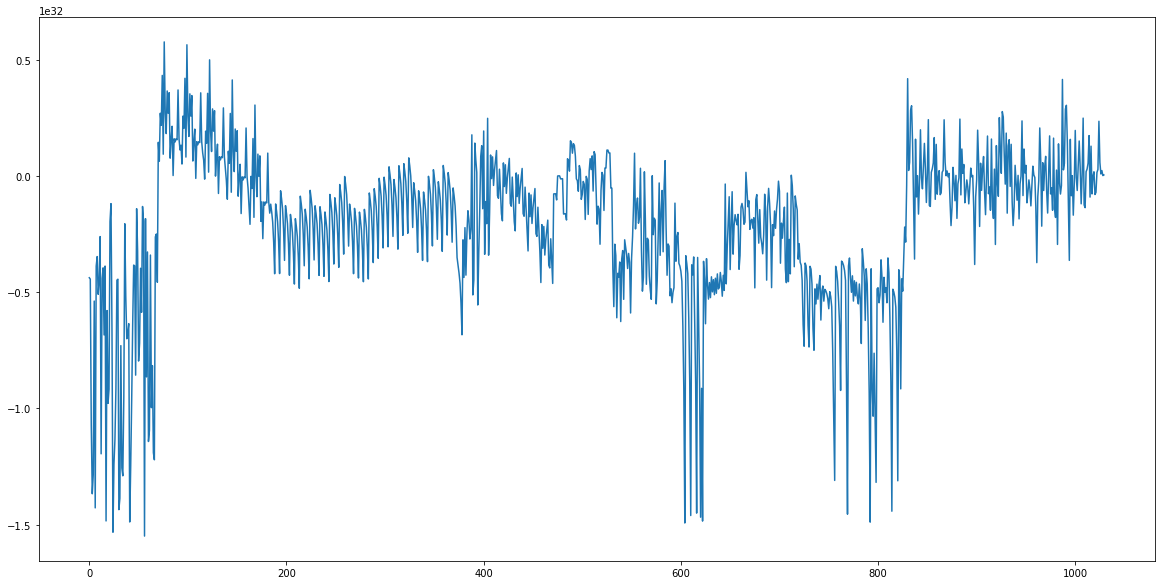

In [15]:
d = LMS(0.2)

d.train(normX, y)

plt.clf()
fig = plt.figure(figsize=(20,10))

plt.plot(d.use(normX))

<h6> Analyzing Least Mean Squares </h6>

> Least Mean Squares gives us a line that is similar to the LS line above but by going one value at a time. We can see that it is also overfitting the model even after normalization of the data. Feeding one data at a time starting at a weight of 0 with the normalized data makes sense that it converges to a similar weight line that the LS line predicted.

In [16]:
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Shuffle the data indices 
    idxs = np.random.permutation(X.index)
    
    # Store the number of data samples 
    N = X.shape[0]
    
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X.iloc[i:, :])
            Ts.append(T.iloc[i:, :])
        else:
            Xs.append(X.iloc[i:i+nrows, :])
            Ts.append(T.iloc[i:i+nrows, :])
        
        i += nrows
    
    return Xs, Ts

In [17]:
Xlst, Tlst = partition(pd.DataFrame(X), pd.DataFrame(y))

In [18]:
Xtrain, Xtest = Xlst[0].values, Xlst[1].values
Ttrain, Ttest = Tlst[0].values, Tlst[1].values

The rmse for the LS model is : 25.70%


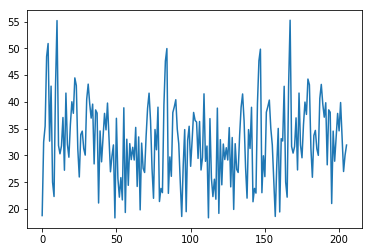

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Xtrain, Ttrain)

pred = lin_reg.predict(Xtest)
plt.plot(pred)
rmse = np.sqrt(np.mean(pred-Ttest)**2) * 100
print("The rmse for the LS model is : {:0.2f}%".format(rmse))

In [20]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(Xtrain, Ttrain)

predictions = lasso_reg.predict(Xtest)
# plt.plot(lasso_reg.predict(Xtest))
rmse = np.sqrt(np.mean(predictions - Ttest)**2) * 100
print("The rmse for the LS model is : {:0.2f}%".format(rmse))


The rmse for the LS model is : 27.08%


In [21]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic.fit(Xtrain, Ttrain)

predictions = elastic.predict(Xtest)
# plt.plot(lasso_reg.predict(Xtest))
rmse = np.sqrt(np.mean(predictions - Ttest)**2) * 100
print("The rmse for the LS model is : {:0.2f}%".format(rmse))


The rmse for the LS model is : 26.98%


<h6> Root Mean Squared Error </h6>

> We see that the root mean squared error is about 33% for the LS and LMS models. This means that between the 80% of training data, when we run the models against the 20% against the test data and have a error rate of 33%. This is obviously not that good and we can see that in the plots that we've constructed above.

# References

> https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength $^{1}$

In [22]:
X = np.array([[2,5],
              [6,2],
              [1,9],
              [4,5],
              [6,3],
              [7,4],
              [8,3]])
T = X[:,0, None] * 3 - 2 * X[:, 1, None] + 3
N = X.shape[0]

def rmse(T, Y):
    return np.sqrt(np.sum((T-Y)**2))

model_names = ['LS', 'LMS_All', 'LMS_1STEP']
models = [LinearRegress(), LMS(0.02), LMS(0.02)]
#train
for i, model in enumerate(models):
    print("training ", model_names[i], "...") 
    if i == len(models) -1: 
        # train only one step for LMS2
        model.train_step(X[0], T[0])
    else:
        model.train(X, T)

def check(a, b, eps=np.finfo(float).eps):
    if abs(a-b) > eps:
        print("failed.", a, b)
    else:
        print("passed.")

errors = [1.19e-13, 2.8753214702, 38.0584918251]
for i, model in enumerate(models):
    print("---- Testing ", model_names[i], "...", end=" ") 
    
    # rmse test
    err = rmse(T, model.use(X))
    if check(err, errors[i], eps=1e-10):
        print ("check your weights: ", model.w)
        print ("oracle: ", )


training  LS ...
training  LMS_All ...
training  LMS_1STEP ...
---- Testing  LS ... passed.
---- Testing  LMS_All ... passed.
---- Testing  LMS_1STEP ... passed.
